# Experiment 0: search for the best hyper parameters

### Using original vector as data representation. <br> 

## Libraries

In [1]:
from __future__ import print_function, division
from astropy.io          import fits
from astropy             import units as u
from astropy.coordinates import SkyCoord

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import OrderedDict
import math

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from torchsummary import summary
from torch.optim.lr_scheduler import LambdaLR, StepLR, MultiStepLR, ExponentialLR
import os
import argparse

import glob
import pickle
import CNN
import os
import sys

# Path

In [2]:
print(os.getcwd())

C:\Users\Administrator\Desktop\0\Experiment_0_search_for_best_model


In [3]:
training_data_kok14_galfa = os.path.join(os.getcwd(),"data", "other", "training_data_kok14_galfa.pickle")

## Data preparation

In [4]:
data = pickle.load(open(training_data_kok14_galfa, 'rb'))

# training data
X_train = data['X_train']
Y_train = data['Y_train']
# Observed test data
X_test = data['X_test']
Y_test = data['Y_test']

In [5]:

x_train, x_test, y_train, y_test = train_test_split(X_train, 
                                                    Y_train, 
                                                    test_size=0.2, 
                                                    shuffle = True, 
                                                    random_state = 8)

x_train, x_val, y_train, y_val = train_test_split(x_train,
                                                  y_train, 
                                                  test_size=0.25, 
                                                  random_state= 8) # 0.25 x 0.8 = 0.2

In [6]:
print("x_train=",x_train.shape, ", y_train=", y_train.shape)
print("x_val=",x_val.shape, ", y_val=", y_val.shape)
print("x_test=",x_test.shape, ", y_test=", y_test.shape)

x_train= (23268, 414) , y_train= (23268, 2)
x_val= (7756, 414) , y_val= (7756, 2)
x_test= (7757, 414) , y_test= (7757, 2)


## Data loader

In [7]:
import data_loader
# initialize dataset
dataset_train = data_loader.spectra_loader(x_train, 
                                           y_train,
                                           transform=data_loader.ToTensor(),
                                           target_transform=data_loader.ToTensor(),
                                           pe=None)

dataset_val = data_loader.spectra_loader(x_val, 
                                         y_val,
                                         transform=data_loader.ToTensor(),
                                         target_transform=data_loader.ToTensor(),
                                         pe=None)

dataset_test = data_loader.spectra_loader(x_test,
                                          y_test,
                                          transform=data_loader.ToTensor(),
                                          target_transform=data_loader.ToTensor(),
                                          pe=None)

In [8]:
# initialize data loader
batch_size = 20 
train_loader = torch.utils.data.DataLoader(dataset = dataset_train,
                                           batch_size = batch_size,
                                           shuffle =True)

valid_loader = torch.utils.data.DataLoader(dataset = dataset_val,
                                           batch_size = batch_size,
                                           shuffle =False)

test_loader = torch.utils.data.DataLoader(dataset = dataset_test, 
                                          batch_size = batch_size,
                                          shuffle =False)

In [9]:
# test data loader
val = iter(test_loader)
A,B = next(val)
print(A.shape)
print(B.shape)

torch.Size([20, 1, 1, 414])
torch.Size([20, 2])


## Model Training and Evaluation 

In [10]:
# train 
def train(epoch):
    """
    Train the model.
    Parameters
    ----------
    epoch : int.
        the index of epoch.
    Returns
    -------
    train_loss/total: The mean MSE in an epoch. 
        
    """
    model.train()
    train_loss = 0
    total = 0
    for index, (inputs, values) in enumerate(train_loader):
        inputs = inputs.float()
        values = values.float()
        inputs, values = inputs.to(device), values.to(device)
        # forward
        outputs = model(inputs)
        loss = loss_function(outputs, values)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # print info
        train_loss = train_loss + (loss.item()*values.size(0)) 
        total += values.size(0)
    print('total loss = ', train_loss)
    return train_loss/total

In [11]:
def validation(epoch):
    """
    validate the model.
    Parameters
    ----------
    epoch : int.
        the index of epoch.

    Returns
    -------
    error: The mean MSE in validation set. 
        
    """
    model.eval()
    global best_err
    test_loss = 0
    total = 0
    with torch.no_grad():
        for index, (inputs, values) in enumerate(valid_loader):
            inputs = inputs.float()
            values = values.float()
            inputs, values = inputs.to(device), values.to(device)
            # forward
            outputs = model(inputs)
            loss = loss_function(outputs, values)
            test_loss = test_loss + (loss.item()*values.size(0))
            total += values.size(0)
    # Save checkpoint.
    error =  test_loss / total
    print(f"validation MSE in epoch {epoch}= ", error)
    if error < best_err:
        print('best_err:', error, 'Saving..')
        state = {'net': model.state_dict(),
                 'err': error,
                 'optimizer_state_dict': optimizer.state_dict(),
                 'epoch': epoch}
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/s2_no_pe.pth')
        best_err = error
    return error

In [12]:
def test(epoch):
    """
    test the model.
    Parameters
    ----------
    epoch : int.
        the index of epoch.
    Returns
    -------
    error: The mean MSE in test set. 
    """
    model.eval()
    global best_err
    test_loss = 0
    total = 0
    with torch.no_grad():
        for index, (inputs, values) in enumerate(test_loader):
            inputs = inputs.float()
            values = values.float()
            inputs, values = inputs.to(device), values.to(device)
            # forward 
            outputs = model(inputs)
            #outputs = outputs.view(outputs[0], 1, outputs[1])
            loss = loss_function(outputs, values)
            test_loss =test_loss+ (loss.item()* values.size(0))
            total += values.size(0)
        return test_loss/total

## Start 10 trail Training

In [13]:
def validate_model(num_output=2,
                   in_channels=1,
                   input_row = 1,
                   input_column=414,
                   num_layer = 10,
                   drop_out_rate=0.30,
                   lpe=False):
    global model
    model =  CNN.spectra_cnn(num_output=num_output,
                             in_channels=in_channels,
                             input_row = input_row,
                             input_column=input_column,
                             num_layer = num_layer,
                             drop_out_rate=drop_out_rate,
                             lpe=lpe)
    num_step = len(X_train)/batch_size
    loss_function = nn.MSELoss()
    best_err = 100000
    checkpoint = torch.load('./checkpoint/s2_no_pe.pth',map_location=torch.device('cuda:0'))
    model.load_state_dict(checkpoint['net'])
    model.to(device)
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    validation_error = validation(epoch)
    test_error = test(epoch)
    return validation_error, test_error

In [14]:
def trail(num_epoch,
          num_output=2,
          in_channels=1,
          input_row = 1,
          input_column=414,
          num_layer = 10,
          drop_out_rate=0.30,
          lpe=False):
    
    global vali
    global testing
    global scheduler
    global model
    global learning_rate
    lr = learning_rate
    #define savor
    global train_trails
    global validate_trails
    global test_trails
    
    model =  CNN.spectra_cnn(num_output=num_output,
                             in_channels=in_channels,
                             input_row = input_row,
                             input_column=input_column,
                             num_layer = num_layer,
                             drop_out_rate=drop_out_rate,
                             lpe=lpe)
    
    for epoch in range(num_epoch):
        train_err = train(epoch)
        vali_err = validation(epoch)
        scheduler.step()
        test_err = test(epoch)
        print('train_err=', train_err)
        # save data
        train_trails.append(train_err)
        validate_trails.append(vali_err)
        test_trails.append(test_err)
    # final test
    validation_error,test_error = validate_model(num_output=num_output,
                                                 in_channels=in_channels,
                                                 input_row = input_row,
                                                 input_column=input_column,
                                                 num_layer = num_layer,
                                                 drop_out_rate=drop_out_rate,
                                                 lpe=lpe)
    print("test err=",test_error)
    vali.append(validation_error)
    testing.append(test_error)

In [45]:
# start 10 trails.
def trail_10(num_trial,
             num_epoch, 
             #
             in_channels,
             input_row,
             input_column,
             num_layer,
             num_output=2,
             drop_out_rate=0.3,
             lpe=False):
    
    global learning_rate
    global vali
    global testing
    global train_trails
    global validate_trails
    global test_trails
    global model
    global optimizer
    global best_err
    global scheduler
    for i in range (0, num_trial):
        print(f'start the {i}th trial:')
        # model initialization
        lr=learning_rate
    
    
        num_step = len(X_train)/batch_size
        loss_function = nn.MSELoss()
        best_err = 100000
        optimizer = torch.optim.SGD(model.parameters(), lr)
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer=optimizer, 
                                                     milestones = [65], 
                                                     gamma=0.1, last_epoch=-1, 
                                                     verbose=False)
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        model.to(device)
        trail(num_epoch = num_epoch,
              input_row = input_row,
              in_channels = in_channels,
              input_column=input_column,
              num_layer = num_layer,
              drop_out_rate=drop_out_rate,
              lpe=lpe,
              num_output=num_output
             )

## Results display methods

In [46]:
def validation_performance(vali):
    x = vali
    plt.figure(figsize=(7,5))
    plt.title('validation performance')
    plt.plot(x, label='validation MSE',marker='o')
    plt.plot([], [], ' ', label=f"mean={round(np.mean(x),6)}")
    plt.plot([], [], ' ', label=f"std={round(np.std(x),6)}")
    plt.xlabel('Trail')
    plt.ylabel('MSE')
    plt.legend()
    plt.grid()
    plt.show()
    print("validation mean=",np.mean(x))
    print("validation std=",np.std(x))

In [47]:
def test_performance(testing):
    x = testing
    plt.figure(figsize=(7,5))
    plt.title('testing performance')
    plt.plot(x, label='testing MSE',marker='o')
    plt.plot([], [], ' ', label=f"mean={round(np.mean(x),6)}")
    plt.plot([], [], ' ', label=f"std={round(np.std(x),6)}")
    plt.xlabel('Trail')
    plt.ylabel('MSE')
    plt.legend()
    plt.grid()
    plt.show()
    print("testing mean=",np.mean(x))
    print("testing std=",np.std(x))

In [48]:
def vali_testing_performance_show(vali, testing):
    x1 = vali
    x2 = testing
    plt.figure(figsize=(7,5))
    plt.title('Two in one')
    plt.plot(x1, label='vaidation_MSE',marker='o')
    plt.plot(x2, label='tesing_MSE',marker='o')
    plt.xlabel('Trail')
    plt.ylabel('MSE')
    plt.legend()
    plt.grid()
    plt.show()

## Save csv methdos

In [49]:
def save_csv(vali, testing, file_name_1, file_name_2):
    x1 = np.array(vali).reshape(1, -1)
    x2 = np.array(testing).reshape(1, -1)
    two = np.vstack((x1,x2))
    df = pd.DataFrame(two).T
    df.to_csv(os.path.join(os.getcwd(),"training_process") + "\\" + file_name_1)
    #
    x3 = np.array(train_trails).reshape(1, -1)
    x4 = np.array(validate_trails).reshape(1, -1)
    x5 = np.array(test_trails).reshape(1, -1)
    three = np.vstack((x3,x4,x5))
    df = pd.DataFrame(three).T
    df.to_csv(os.path.join(os.getcwd(),"training_process") + "\\"+ file_name_2)

## Start training for layer number = [2, 4, 6, 8, 10, 12, 14, 16]

In [60]:
num_layer = [ 8, 10, 12, 14, 16]

num_layer= 8
start the 0th trial:
total loss =  479.63817103300244
validation MSE in epoch 0=  0.009398281598264805
best_err: 0.009398281598264805 Saving..
train_err= 0.020613639807160154
total loss =  253.59649008046836
validation MSE in epoch 1=  0.010296306961425928
train_err= 0.010898938029932454
total loss =  234.44566010776907
validation MSE in epoch 2=  0.008045642238658819
best_err: 0.008045642238658819 Saving..
train_err= 0.010075883621616342
total loss =  224.6170659312047
validation MSE in epoch 3=  0.009324238395324152
train_err= 0.009653475413924906
total loss =  214.11264103883877
validation MSE in epoch 4=  0.007622948305740426
best_err: 0.007622948305740426 Saving..
train_err= 0.009202021705296493
total loss =  204.46711240173317
validation MSE in epoch 5=  0.008668758243084858
train_err= 0.008787481193129327
total loss =  192.64855560427532
validation MSE in epoch 6=  0.008401035418486113
train_err= 0.008279549407094522
total loss =  181.16900635277852
validation MSE i

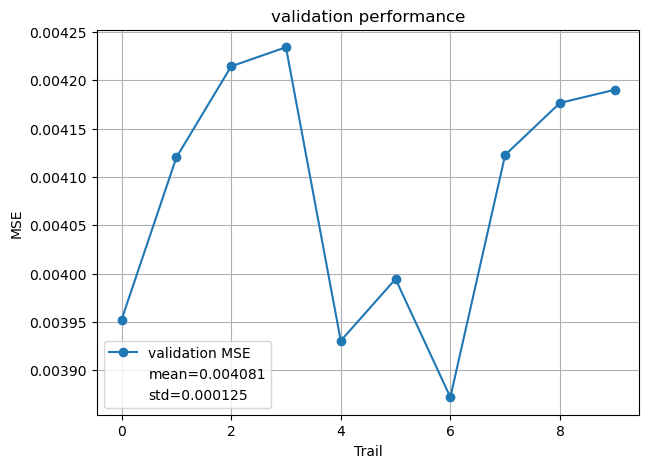

validation mean= 0.004080756977177693
validation std= 0.00012498568826892255


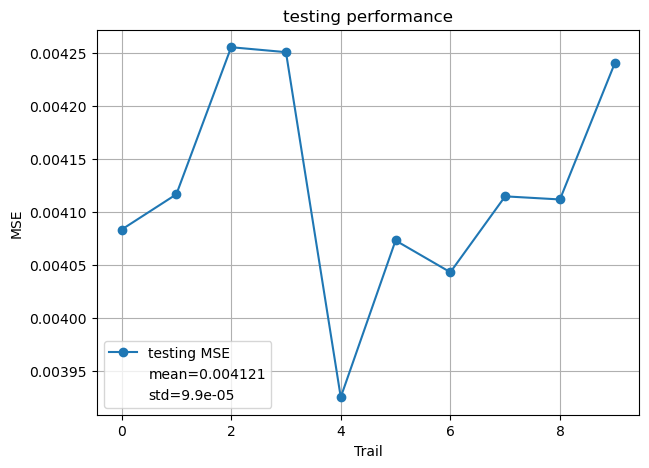

testing mean= 0.004121234170895519
testing std= 9.868083731438659e-05


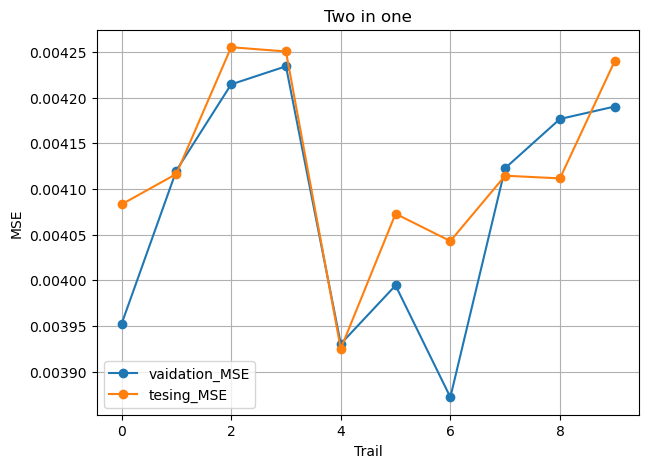

num_layer= 10
start the 0th trial:
total loss =  389.1655334220268
validation MSE in epoch 0=  0.010662823235361524
best_err: 0.010662823235361524 Saving..
train_err= 0.016725353851728846
total loss =  269.4254607670009
validation MSE in epoch 1=  0.009000277632471345
best_err: 0.009000277632471345 Saving..
train_err= 0.011579227297876951
total loss =  244.65626261895522
validation MSE in epoch 2=  0.011226513253235752
train_err= 0.010514709584792644
total loss =  228.26808506483212
validation MSE in epoch 3=  0.010335588638366706
train_err= 0.009810387014991925
total loss =  211.15132277924567
validation MSE in epoch 4=  0.006776535172776
best_err: 0.006776535172776 Saving..
train_err= 0.009074751709611728
total loss =  197.54494979139417
validation MSE in epoch 5=  0.006221575329218073
best_err: 0.006221575329218073 Saving..
train_err= 0.00848998408936712
total loss =  184.07376872980967
validation MSE in epoch 6=  0.009381046665418372
train_err= 0.007911026677402858
total loss =  17

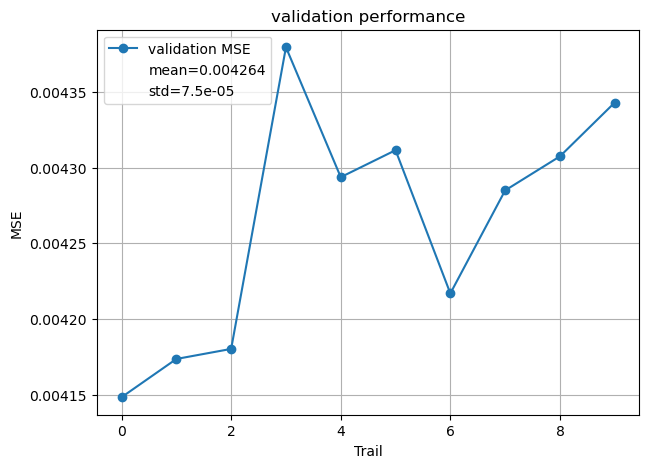

validation mean= 0.004263957141932914
validation std= 7.465818379505063e-05


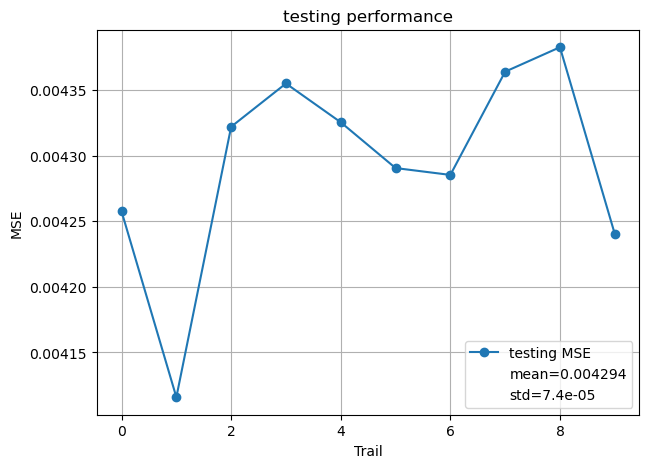

testing mean= 0.004293895689396285
testing std= 7.367668898105507e-05


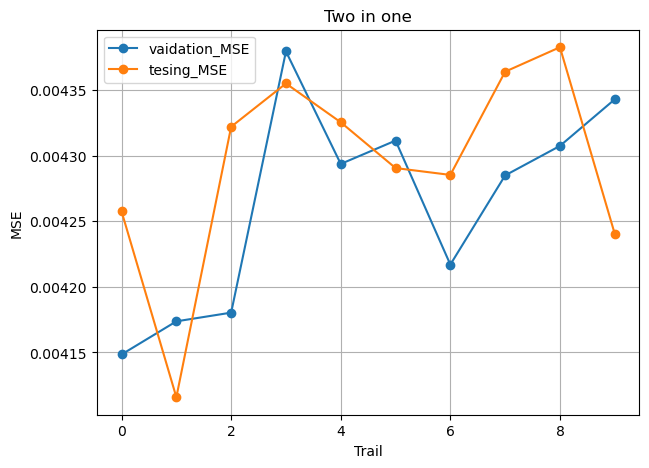

num_layer= 12
start the 0th trial:
total loss =  369.52379925502464
validation MSE in epoch 0=  0.010033416989739252
best_err: 0.010033416989739252 Saving..
train_err= 0.01588120161831806
total loss =  247.19134789705276
validation MSE in epoch 1=  0.01304554366583486
train_err= 0.010623661161124839
total loss =  227.61761792749166
validation MSE in epoch 2=  0.010413697007909041
train_err= 0.009782431576735933
total loss =  217.0103601757437
validation MSE in epoch 3=  0.00917295065622963
best_err: 0.00917295065622963 Saving..
train_err= 0.00932655837097059
total loss =  207.50976374465972
validation MSE in epoch 4=  0.02408738966619134
train_err= 0.008918246679760173
total loss =  197.75371602224186
validation MSE in epoch 5=  0.009856304571640358
train_err= 0.008498956335836421
total loss =  183.46687574195676
validation MSE in epoch 6=  0.011675537589917276
train_err= 0.007884943946276292
total loss =  175.45195249002427
validation MSE in epoch 7=  0.014235497653809034
train_err= 0

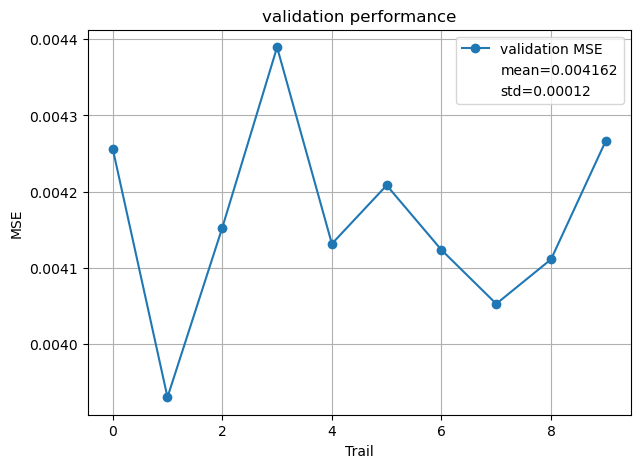

validation mean= 0.004162435619034871
validation std= 0.00012015306750219924


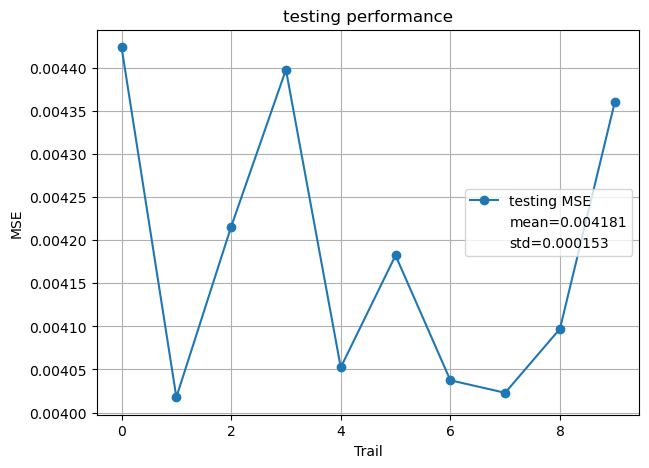

testing mean= 0.004180899342979522
testing std= 0.0001534994379010381


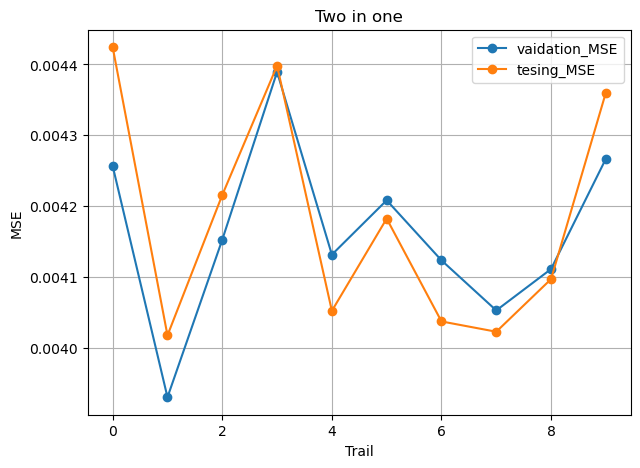

num_layer= 14
start the 0th trial:
total loss =  363.7688904311508
validation MSE in epoch 0=  0.028362784631955695
best_err: 0.028362784631955695 Saving..
train_err= 0.01563387014058582
total loss =  257.1381406933069
validation MSE in epoch 1=  0.010063825603062983
best_err: 0.010063825603062983 Saving..
train_err= 0.011051149247606452
total loss =  239.31754081789404
validation MSE in epoch 2=  0.008439774950413882
best_err: 0.008439774950413882 Saving..
train_err= 0.010285264776426595
total loss =  225.46924403170124
validation MSE in epoch 3=  0.008647904368878745
train_err= 0.009690099881025496
total loss =  215.84678143193014
validation MSE in epoch 4=  0.008425906453283562
best_err: 0.008425906453283562 Saving..
train_err= 0.009276550689011953
total loss =  196.01130153331906
validation MSE in epoch 5=  0.007210740723391172
best_err: 0.007210740723391172 Saving..
train_err= 0.008424071752334497
total loss =  186.88605491956696
validation MSE in epoch 6=  0.012272130550450178
tr

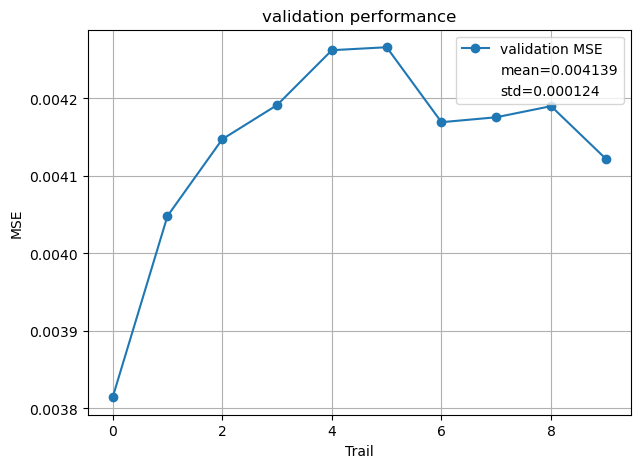

validation mean= 0.004138688374909738
validation std= 0.00012363846775271227


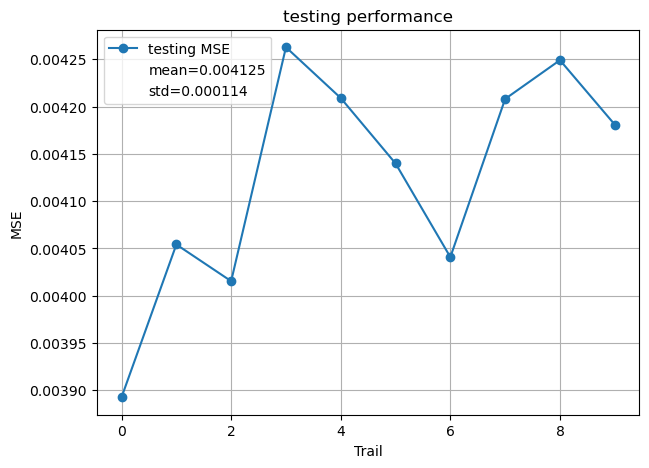

testing mean= 0.0041252725588520845
testing std= 0.00011386693696704369


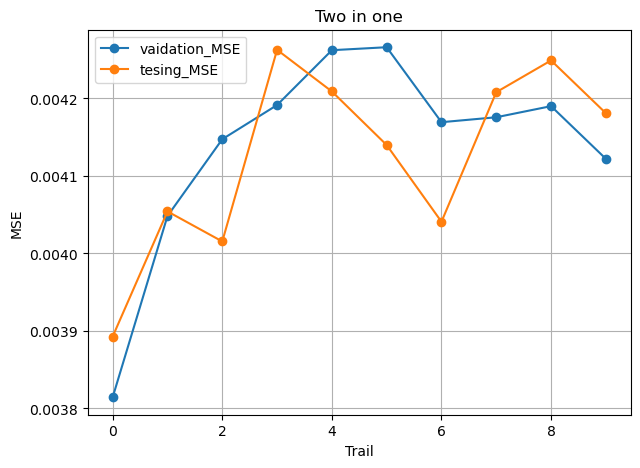

num_layer= 16
start the 0th trial:
total loss =  391.9059796826914
validation MSE in epoch 0=  0.010486308650256295
best_err: 0.010486308650256295 Saving..
train_err= 0.016843131325541147
total loss =  264.1142321168445
validation MSE in epoch 1=  0.009061020840588109
best_err: 0.009061020840588109 Saving..
train_err= 0.011350964075848569
total loss =  245.99292719829828
validation MSE in epoch 2=  0.010398072582576376
train_err= 0.010572156059751515
total loss =  236.4814453329891
validation MSE in epoch 3=  0.008652914564112992
best_err: 0.008652914564112992 Saving..
train_err= 0.010163376540011565
total loss =  230.18669055355713
validation MSE in epoch 4=  0.00836742760440889
best_err: 0.00836742760440889 Saving..
train_err= 0.009892843843628894
total loss =  224.07588159432635
validation MSE in epoch 5=  0.008099326558947628
best_err: 0.008099326558947628 Saving..
train_err= 0.009630216675018323
total loss =  220.63146911980584
validation MSE in epoch 6=  0.008545832933443529
trai

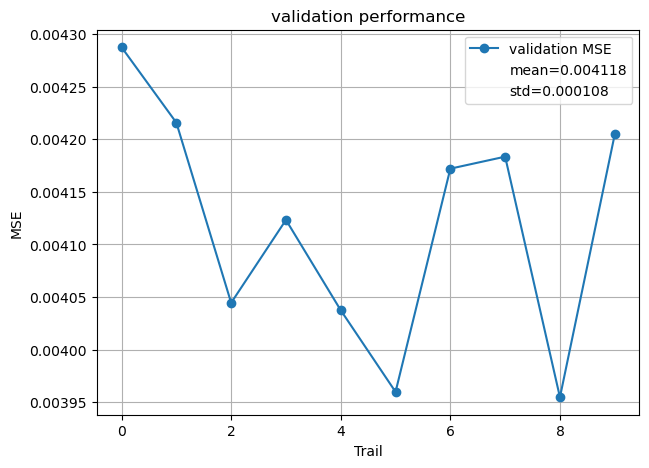

validation mean= 0.004118292789764031
validation std= 0.00010797582071878161


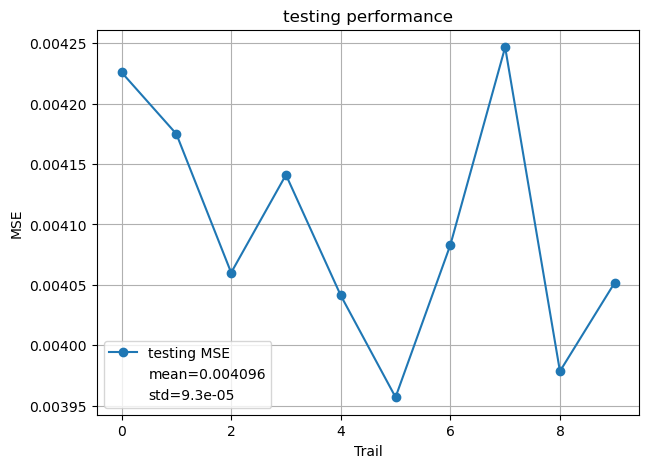

testing mean= 0.004095995931193407
testing std= 9.346304852383794e-05


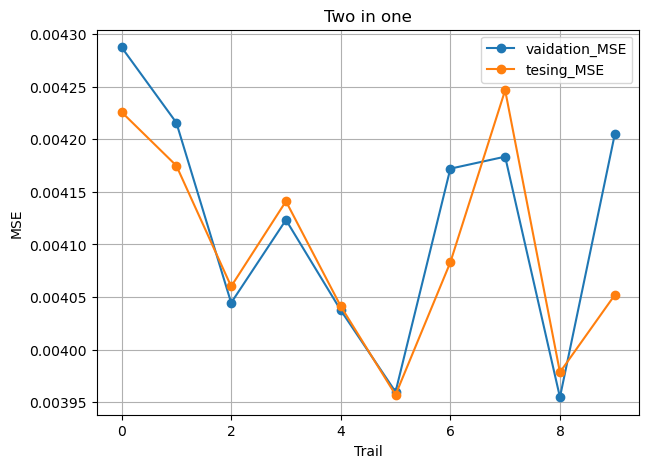

In [61]:
for i in num_layer:
    global  learning_rate
    learning_rate = 0.005
    global vali
    global testing
    global train_trails
    global validate_trails
    global test_trails
    # the savier of best validation performance and coresponding testing performance.
    vali = []
    testing = []
    # saver for each trials
    train_trails = []
    validate_trails =[]
    test_trails = []
    print("num_layer=", i)
    global device
    device = 'cuda:0'
    global loss_function
    
    loss_function = nn.MSELoss()
    
    trail_10(num_trial = 10,
             num_epoch = 80, 
             #
             in_channels = 1,
             input_row=1,
             input_column=414,
             num_layer = i,
             num_output=2,
             drop_out_rate=0.3,
             lpe=False)
    validation_performance(vali)
    test_performance(testing)
    vali_testing_performance_show(vali, testing)
    file_name_1 = f'num_layer_{i}.csv'
    file_name_2 = f'num_layer_{i}_process.csv'
    save_csv(vali, testing, file_name_1, file_name_2)

In [62]:
num_layer = [4, 6]

num_layer= 4
start the 0th trial:
total loss =  559.3600238412619
validation MSE in epoch 0=  0.05901327421249896
best_err: 0.05901327421249896 Saving..
train_err= 0.024039884125892294
total loss =  318.6767745614052
validation MSE in epoch 1=  0.012063454191789776
best_err: 0.012063454191789776 Saving..
train_err= 0.013695924641628209
total loss =  287.9319048477337
validation MSE in epoch 2=  0.011875364799513575
best_err: 0.011875364799513575 Saving..
train_err= 0.012374587624537291
total loss =  255.10305564198643
validation MSE in epoch 3=  0.0076189651851633075
best_err: 0.0076189651851633075 Saving..
train_err= 0.010963686420920854
total loss =  234.6795395114459
validation MSE in epoch 4=  0.01021273417459333
train_err= 0.010085935168963637
total loss =  220.9618682442233
validation MSE in epoch 5=  0.009324112020038133
train_err= 0.009496384229165518
total loss =  207.2666034917347
validation MSE in epoch 6=  0.009329172885266352
train_err= 0.008907796264901784
total loss =  2

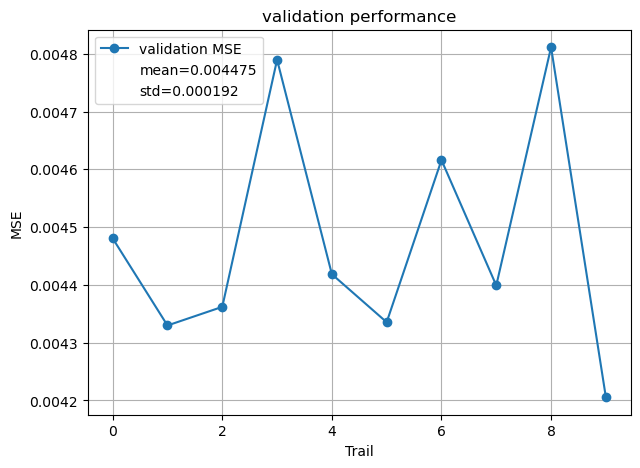

validation mean= 0.004474804936709756
validation std= 0.00019165290737866532


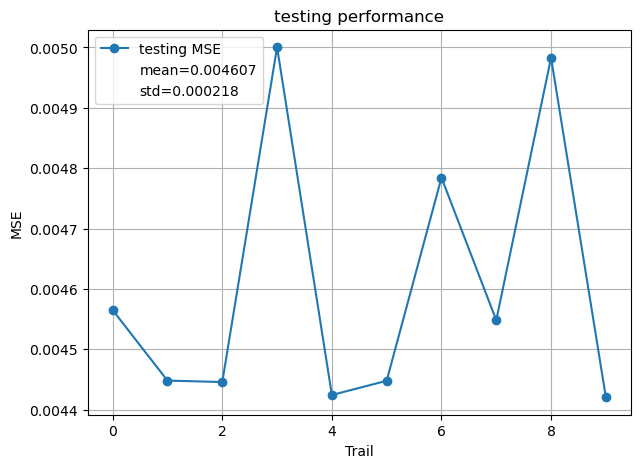

testing mean= 0.004606688618453766
testing std= 0.00021849242937017834


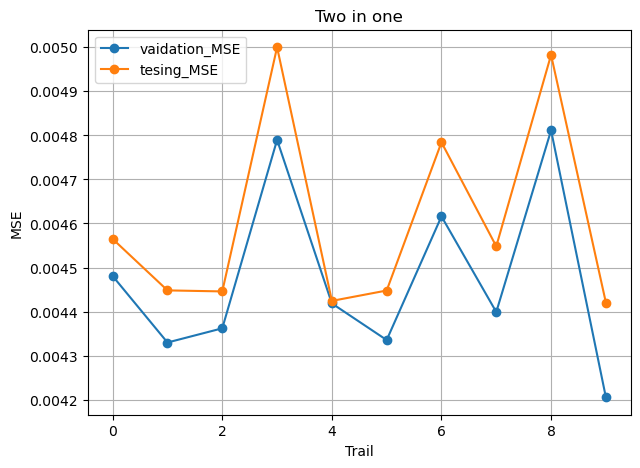

num_layer= 6
start the 0th trial:
total loss =  708.4976480929181
validation MSE in epoch 0=  0.019609119575480293
best_err: 0.019609119575480293 Saving..
train_err= 0.030449443359675008
total loss =  300.04919122578576
validation MSE in epoch 1=  0.0163654212445086
best_err: 0.0163654212445086 Saving..
train_err= 0.012895358055087921
total loss =  254.7585396762006
validation MSE in epoch 2=  0.009597001217599611
best_err: 0.009597001217599611 Saving..
train_err= 0.010948879992960315
total loss =  237.32608525222167
validation MSE in epoch 3=  0.007969315182403222
best_err: 0.007969315182403222 Saving..
train_err= 0.01019967703507915
total loss =  224.94572792155668
validation MSE in epoch 4=  0.010351767435923503
train_err= 0.009667600477976478
total loss =  219.8937129159458
validation MSE in epoch 5=  0.008679741941793
train_err= 0.009450477605120586
total loss =  208.12798814522102
validation MSE in epoch 6=  0.007950835025765083
best_err: 0.007950835025765083 Saving..
train_err= 

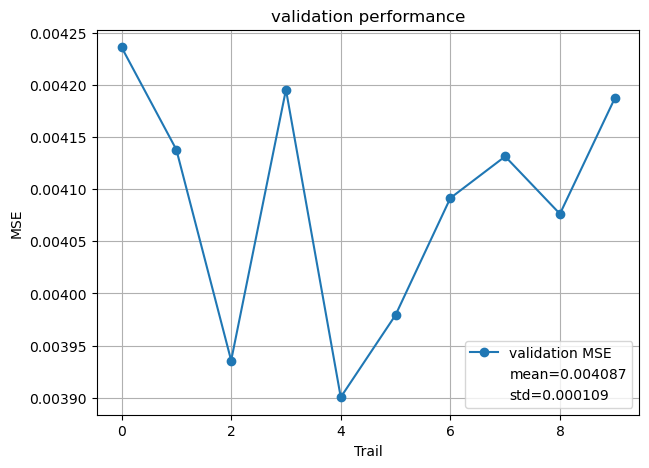

validation mean= 0.004087056500498048
validation std= 0.00010857989820894959


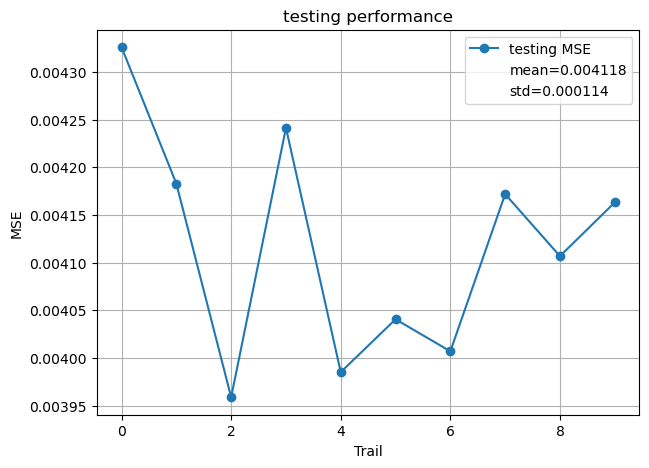

testing mean= 0.004118379743914319
testing std= 0.00011363020481258891


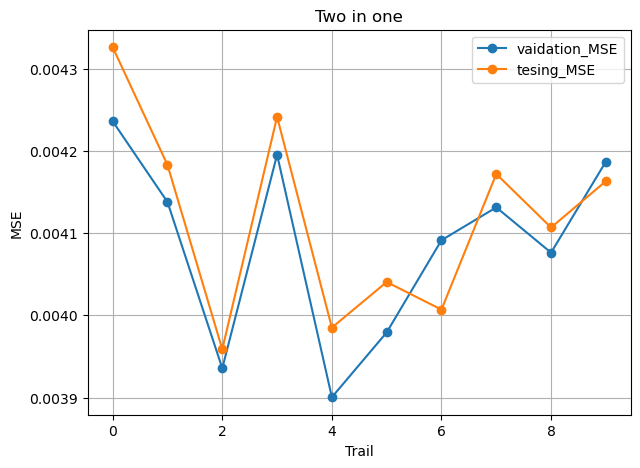

In [63]:
for i in num_layer:
    global  learning_rate
    learning_rate = 0.005
    global vali
    global testing
    global train_trails
    global validate_trails
    global test_trails
    # the savier of best validation performance and coresponding testing performance.
    vali = []
    testing = []
    # saver for each trials
    train_trails = []
    validate_trails =[]
    test_trails = []
    print("num_layer=", i)
    global device
    device = 'cuda:0'
    global loss_function
    loss_function = nn.MSELoss()
    
    trail_10(num_trial = 10,
             num_epoch = 80, 
             #
             in_channels = 1,
             input_row=1,
             input_column=414,
             num_layer = i,
             num_output=2,
             drop_out_rate=0.3,
             lpe=False)
    validation_performance(vali)
    test_performance(testing)
    vali_testing_performance_show(vali, testing)
    file_name_1 = f'num_layer_{i}.csv'
    file_name_2 = f'num_layer_{i}_process.csv'
    save_csv(vali, testing, file_name_1, file_name_2)

In [64]:
num_layer = [2]

num_layer= 2
start the 0th trial:
total loss =  607.202285581734
validation MSE in epoch 0=  0.026628625422597023
best_err: 0.026628625422597023 Saving..
train_err= 0.026096023963457712
total loss =  367.62524986919016
validation MSE in epoch 1=  0.011915880450767538
best_err: 0.011915880450767538 Saving..
train_err= 0.01579960675043795
total loss =  337.12755413912237
validation MSE in epoch 2=  0.019125019411963245
train_err= 0.014488892648234587
total loss =  314.9489715145901
validation MSE in epoch 3=  0.008614764383551196
best_err: 0.008614764383551196 Saving..
train_err= 0.013535713061483157
total loss =  289.97195414081216
validation MSE in epoch 4=  0.01392505081517448
train_err= 0.012462263801822767
total loss =  278.6755191059783
validation MSE in epoch 5=  0.013751726990561815
train_err= 0.011976771493294581
total loss =  260.03905254928395
validation MSE in epoch 6=  0.017378860752445525
train_err= 0.011175823128299981
total loss =  256.7346953013912
validation MSE in epoc

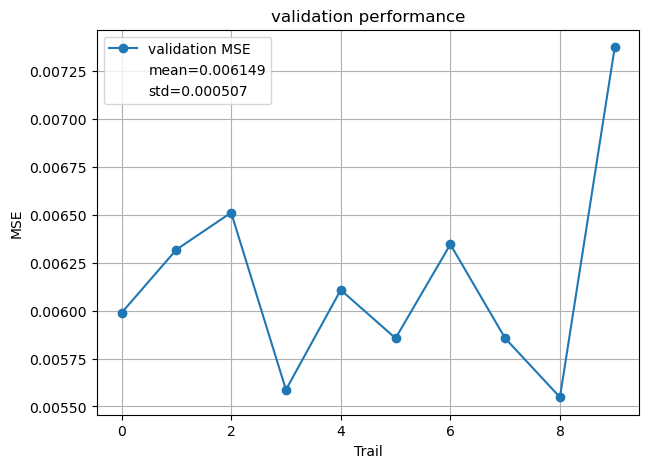

validation mean= 0.006148855754782726
validation std= 0.0005071086521605273


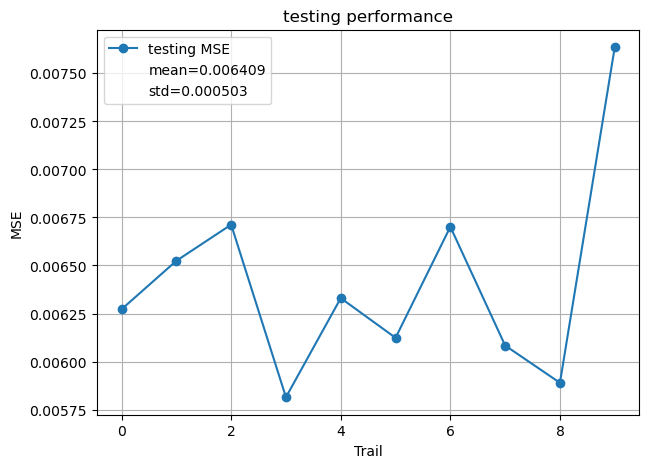

testing mean= 0.006408657966474827
testing std= 0.0005033120982513375


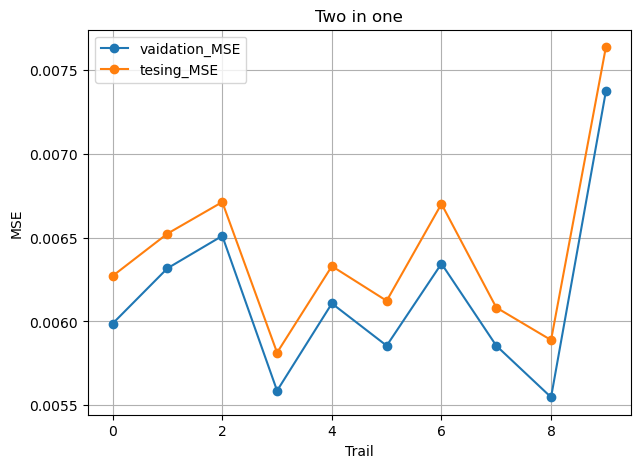

In [65]:
for i in num_layer:
    global  learning_rate
    learning_rate = 0.002
    global vali
    global testing
    global train_trails
    global validate_trails
    global test_trails
    # the savier of best validation performance and coresponding testing performance.
    vali = []
    testing = []
    # saver for each trials
    train_trails = []
    validate_trails =[]
    test_trails = []
    print("num_layer=", i)
    global device
    device = 'cuda:0'
    global loss_function
    loss_function = nn.MSELoss()
    
    trail_10(num_trial = 10,
             num_epoch = 80, 
             #
             in_channels = 1,
             input_row=1,
             input_column=414,
             num_layer = i,
             num_output=2,
             drop_out_rate=0.3,
             lpe=False)
    validation_performance(vali)
    test_performance(testing)
    vali_testing_performance_show(vali, testing)
    file_name_1 = f'num_layer_{i}.csv'
    file_name_2 = f'num_layer_{i}_process.csv'
    save_csv(vali, testing, file_name_1, file_name_2)